# L'ensemble de Mandelbrot
-Pablo DI MUZIO

## Représentation graphique en python

### Résumé du fonctionnement

Pour savoir si un nombre complexe appartient à l'ensemble de Mandelbrot on doit vérifier que si itérer un nombre pseudo-infini de fois par la suite
$
\begin{cases}
z_0=0\\
z_{n+1}=z_n^2+c
\end{cases}
$, le resultat reste borné.

Le fonctionnement algorithmique devrait ressembler à cela:

- On divise le plan en point de coordonnée fixes d'affixe $z$(pour + de précision, 1 coordonée = 1px)
- On cherche si, pendant un grand nombre d'itération, $\exists k, K \in \R | k < \mod{z_n} < K$ alors, on donne une coloration particulière au pixel.
- On itère sur tous les pixels

### Partie 1: Code fonctionnel

#### Imports des packages

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mpc
from tqdm import tqdm

#### Création des constantes

Ici, on choisis la valeur maximale que nos axes doivent prendre, par exemple, avec
```python
maxX = 1.5
minX = -2
maxY = 1.75
minY = -1.75
pixelAmount = 1000
```
On a comme zone de rendu le rectangle de coin suppérieur droit $(1.5+1.75i)$ et inférieur gauche $(-2-1.75i)$ avec une résolution de 1000 pixel de coté

In [9]:
maxX = 1.5
minX = -2
maxY = 1.75
minY = -1.75
pixelAmount = 1000

#### Génération de la grille

Je me suis ici inspiré du site <https://realpython.com/mandelbrot-set-python/> pour optenir une grille complexe à l'aide de numpy.

In [21]:
Re = np.linspace(minX, maxX, pixelAmount)
Im = np.linspace(minY, maxY, pixelAmount)

grilleComplexe = Re[np.newaxis, :] + Im[:, np.newaxis] * 1j
grilleImage = Re[np.newaxis, :] + Im[:, np.newaxis]

On crée maintenant une fonction qui va nous permettre de savoir si un élement appartient à l'ensemble de mandelbrot ou non.
On choisit la constante qui nous indique si le module du nombre est trop grande comme 2 car l'ensemble de Mandelbrot est contenu dans le cercle de rayon 2.

In [22]:
def evaluate(c, z = 0, maxIter = 30):
    for k in range(maxIter):
        z = z**2 + c
        if (np.abs(z) > 2):
            return k
    return maxIter


On peut donc désormais juste loop sur tous les élements de notre plan complexe pour retrouver notre ensemble de Mandelbrot

In [23]:
for i in tqdm(range(grilleComplexe.shape[0])):
    for j in range(grilleComplexe.shape[1]):
        grilleImage[i][j] = evaluate(grilleComplexe[i][j])

100%|██████████| 1000/1000 [00:11<00:00, 86.16it/s]


On a juste désormais à utiliser la fonction `imshow` de MathPlotLib pour grapher optenir une image continue de notre ensemble

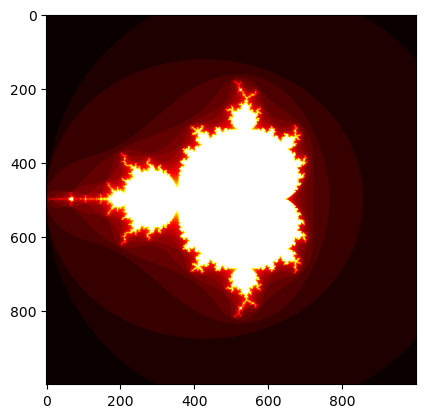

In [24]:
plt.imshow(grilleImage, cmap="hot", vmin=0, vmax=30)

J'ai utilisé le marqueur `%%timeit` pour évaluer le temps moyen de génération, j'ai donc remarqué que le programme mettait en moyenne était de 7 secondes sur ma machine pour une image de seulement 1000x1000 pixels.

### Partie 2: Optimisation

On a un super resultat mais j'aimerais avoir la possibilité de produire une image très haute qualité en le moins de temps possible. Je vais donc tenter des amélioration de la méthode pour avoir un objet le plus net possible !

On sait que la partie qui est la plus demandante en temps est notre boucle imbriqué. On peut donc utiliser des astuces pour accelerer notre programme. On va donc utiliser plusieurs Threads de notre ordinateurs pour faire plusieurs taches simultanées. Comme mon ordinateur est munis de 12 Threads, j'essaye de tous les utiliser en même temps.

In [25]:
def eval_point(i, j):
    return evaluate(grilleComplexe[i][j])

# Inserer dans la fonction Pool() le nombre de Threads à utiliser
res = mpc.Pool(12).starmap(eval_point, tqdm([(i,j) for i in range(grilleComplexe.shape[0]) for j in range(grilleComplexe.shape[1])]))

grilleImage = np.reshape(np.array(res), (-1, grilleImage.shape[1]))

100%|██████████| 1000000/1000000 [00:02<00:00, 459096.32it/s]


Sur mon ordinateur je me retrouve avec un temps d'environ 1 seconde et demie. On a donc effectivement multiplier par 12 la vitesse de notre programme.

On veut ensuite visualier le resultat. On introduit ici une nouvelle méthode de visualisation d'images. En effet, mon IDE et Jupyter Lab compressent les images avant de me laisser les visualiser, je les sauvegarde donc localement dans le même repertoire que ce fichier.
Afin de rendre le fichier jupyter moins vide et plus facile à naviger, on laisse tout de même la prévisualisation de moindre qualité.

In [26]:
plt.imsave('img.png' , grilleImage, cmap="hot", vmin=0, vmax=30)

On sauvegarde l'image `img.png` que je vous invite à visualiser. Sinon, voici à quoi elle ressemble (en plus pixelisé)

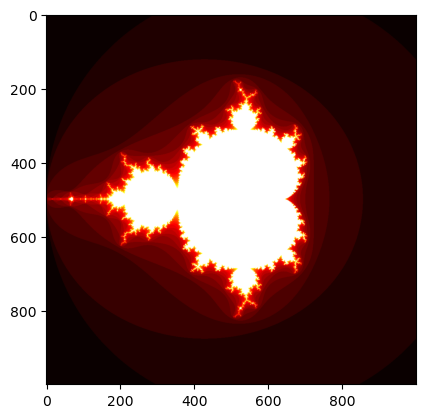

In [27]:
plt.imshow(plt.imread('img.png'))

### Partie 3: L'ensemble de Julia
L'ensemble de Julia est un ensemble de fractale incluant celle de Mandelbrot, on peut réutiliser une partie du code précédent pour en générer l'explorer des nouvelles fractales.

En réalité, le code est quasiment le même qu'à l'origine à deux ou trois détails près:
On itère un certains nombre de fois chacuns des nombres complexes de notre grille puis on colorie les pixels correspondants en fonction de la vitesse de divergence de ces nombres.

Je vous invite vivement à essayer de changer les valeurs du paramètre `c` (nombre complexe) pour voir les résultats possibles !

In [7]:
def evaluateJulia(z, c = 0, maxIter = 90):
    for k in range(maxIter):
        z = z**2 + c
        if (np.abs(z) > 10):
            return k
    return maxIter

In [29]:
#On utilise cette variable pour modifier le nombre d'itération
mIter = 250

def eval_julia_point(i, j):
    # pour jouer avec les formes des fractales générées, modifier le param c ici !
    return evaluateJulia(grilleComplexe[i][j], c = -0.4+0.6j, maxIter=mIter)

res = mpc.Pool(12).starmap(eval_julia_point, tqdm([(i,j) for i in range(grilleComplexe.shape[0]) for j in range(grilleComplexe.shape[1])]))

grilleImage = np.reshape(np.array(res), (-1, grilleImage.shape[1]))

100%|██████████| 1000000/1000000 [00:03<00:00, 265258.48it/s]


In [30]:
plt.imsave('julia.png' , grilleImage, cmap="twilight", vmin=0, vmax=mIter)

On visualise notre image:

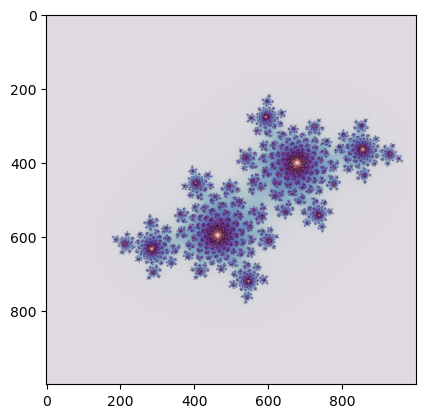

In [32]:
plt.imshow(plt.imread('julia.png'))

On se rend compte en jouant avec les paramètres que pour tirer le maximum de notre image il faut pouvoir mieux la centrer et gérer le ratio $x/y$

In [4]:
maxX = 1.778
minX = -1.778
maxY = 1
minY = -1
pixelAmountX = 7680
pixelAmountY = 4320

Ici j'ai utilisé des valeurs pour optenir une image en 8K.

In [5]:
Re = np.linspace(minX, maxX, pixelAmountX)
Im = np.linspace(minY, maxY, pixelAmountY)

grilleComplexe = Re[np.newaxis, :] + Im[:, np.newaxis] * 1j
grilleImage = Re[np.newaxis, :] + Im[:, np.newaxis]

In [8]:
mIter = 250

def eval_julia_point(i, j):
    return evaluateJulia(grilleComplexe[i][j],c=-0.8+0.156j, maxIter=mIter)

res = mpc.Pool(12).starmap(eval_julia_point, tqdm([(i,j) for i in range(grilleComplexe.shape[0]) for j in range(grilleComplexe.shape[1])]))

grilleImage = np.reshape(np.array(res), (-1, grilleImage.shape[1]))

100%|██████████| 33177600/33177600 [02:50<00:00, 195058.62it/s] 


In [9]:
plt.imsave('fractale.png' , grilleImage, cmap="twilight_shifted", vmin=0, vmax=mIter)

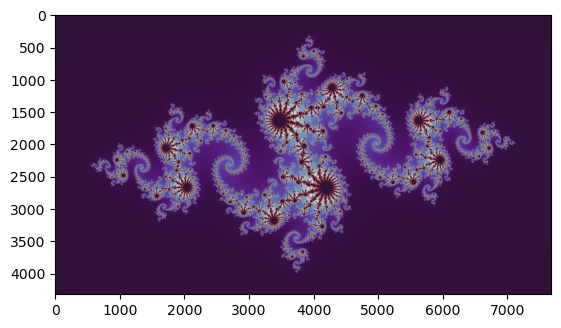

In [10]:
plt.imshow(plt.imread('fractale.png'))

Je me suis donc amusé à générer d'autres fractales

### Et ensuite ?

Je suis à cours de temps pour coder avant la deadline de vendredi mais voici quelques points que je pourrais reprendre dans mon programme pour l'optimiser et améliorer le rendu en direct:
- Implémenter la prévisualisation de l'image pendant le rendu:
On pourrait voir les pixels se générer pendant le rendu afin de ne pas à avoir à attendre 5 minutes devant un écran noir pour savoir si c'est le resultat rechercher.
- Implémenter une méthode de rendu "par Chunk":
Il s'agit de découper mon image en secteurs afin de faire des rendus rapides que j'affine après: en effet, il ne sert à rien de générer tous les pixels d'un secteur si celui-ci est vide. Ainsi après des découpages succéssifs je devrais pouvoir optenir un rendu plus rapide